In [2]:
import ibis

In [6]:
'''
con = ibis.postgres.connect(
    host='localhost', user='user', password='pass',
    port=5432, database='dbname'
)
'''

In [25]:
ibis.options.interactive = False
ibis.options.sql.default_limit = 100
ibis.options.verbose = False

In [21]:
t = ibis.table(
    [('one', 'string'),
     ('two', 'double'),
     ('three', 'int32')], 'my_data')

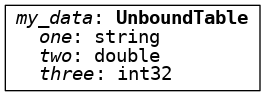

In [27]:
t

In [28]:
proj = t['two', 'one']

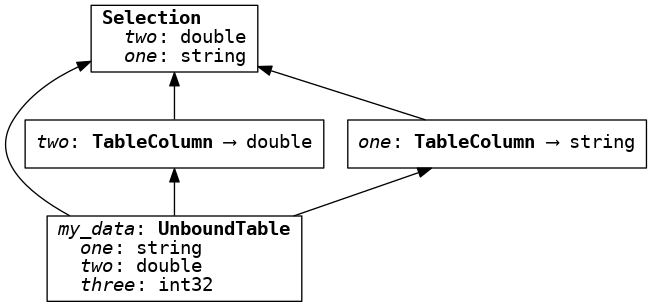

In [30]:
proj

In [35]:
print(ibis.postgres.compile(proj))

SELECT t0.two, t0.one 
FROM my_data AS t0


In [36]:
new_col = (t.three * 2).name('new_col')
proj = t['two', 'one', new_col]
print(ibis.impala.compile(proj))

SELECT `two`, `one`, `three` * 2 AS `new_col`
FROM my_data


In [37]:
mutated = t.mutate(new_col=t.three * 2)
print(ibis.impala.compile(mutated))

SELECT *, `three` * 2 AS `new_col`
FROM my_data


In [38]:
mutated = t.mutate(two=t.two * 2)
print(ibis.impala.compile(mutated))

SELECT `one`, `two` * 2 AS `two`, `three`
FROM my_data


In [39]:
proj = t[t]
print(ibis.impala.compile(proj))

SELECT *
FROM my_data


In [41]:
proj = t[t, new_col]
print(ibis.impala.compile(proj))

SELECT *, `three` * 2 AS `new_col`
FROM my_data


In [43]:
mutated = t.mutate(four=t.two * 2)
print(ibis.impala.compile(mutated))

SELECT *, `two` * 2 AS `four`
FROM my_data


In [44]:
t2 = ibis.table(
    [('key', 'string'),
     ('value', 'double')], 'dim_table')

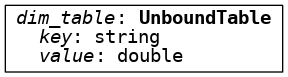

In [46]:
t2

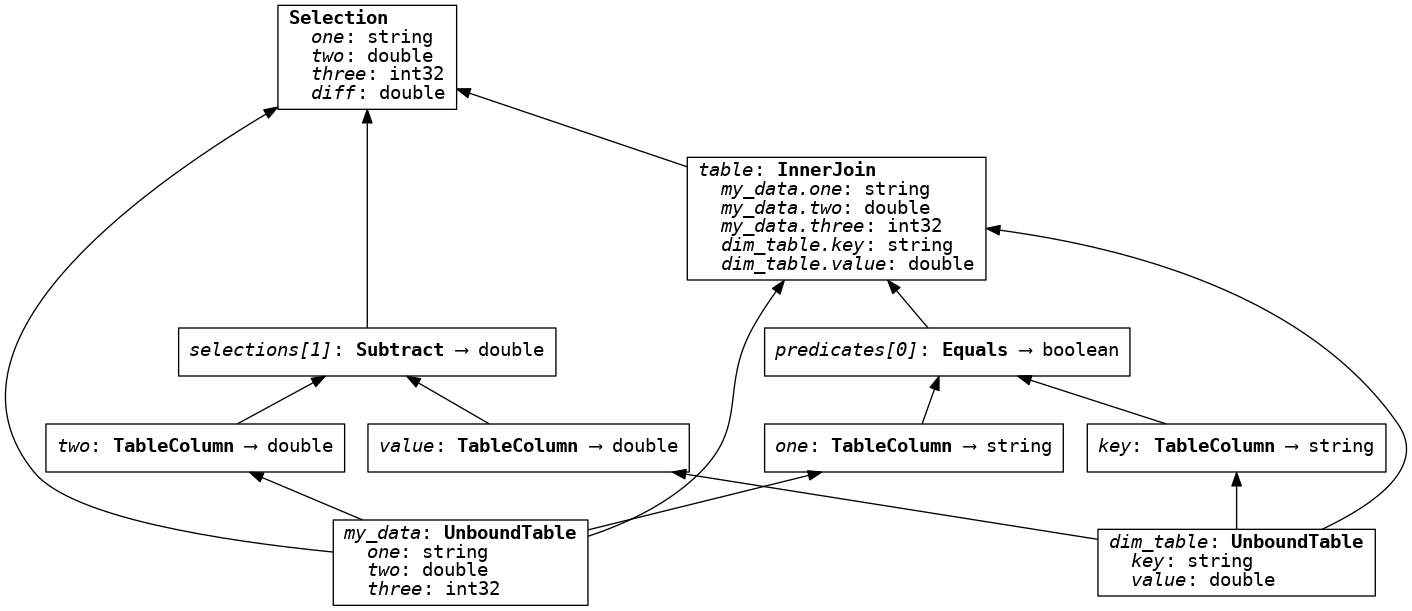

In [47]:
diff = (t.two - t2.value).name('diff')
joined = t.join(t2, t.one == t2.key)[t, diff]
joined

In [51]:
print(ibis.postgres.compile(joined))

SELECT t0.one, t0.two, t0.three, t0.two - t1.value AS diff 
FROM my_data AS t0 JOIN dim_table AS t1 ON t0.one = t1.key


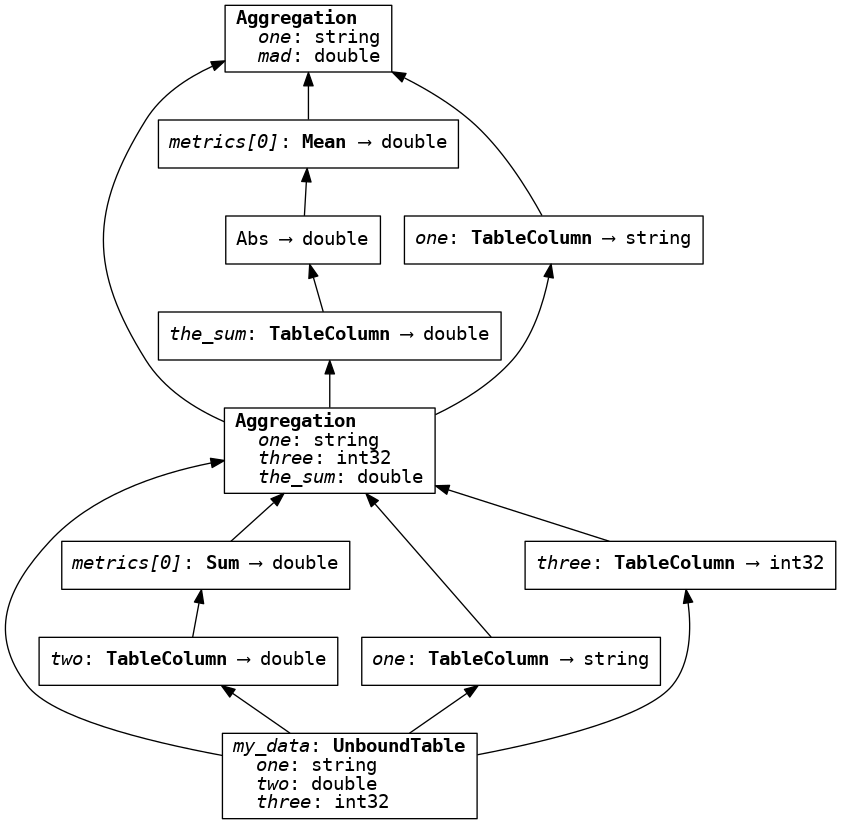

In [54]:
expr = (
    t.group_by(['one', 'three'])
        .aggregate(the_sum=t.two.sum())
        .group_by('one')
        .aggregate(mad=lambda x: x.the_sum.abs().mean())
)
expr

In [55]:
print(ibis.postgres.compile(expr))

SELECT t0.one, avg(abs(t0.the_sum)) AS mad 
FROM (SELECT t1.one AS one, t1.three AS three, sum(t1.two) AS the_sum 
FROM my_data AS t1 GROUP BY t1.one, t1.three) AS t0 GROUP BY t0.one


In [56]:
def mad(field):
    def closure(table):
        return table[field].abs().mean()
    return closure

In [57]:
expr = (
    t.group_by(['one', 'three'])
        .aggregate(the_sum=t.two.sum())
        .group_by('one')
        .aggregate(mad=mad('the_sum')))

In [59]:
filtered = t[t.two > 0][t.one]
print(ibis.impala.compile(filtered))

SELECT `one`
FROM my_data
WHERE `two` > 0


In [60]:
filtered = t.filter([
    t.two > 0,
    t.one.isin(['A', 'B'])
])
print(ibis.impala.compile(filtered))

SELECT *
FROM my_data
WHERE `two` > 0 AND
      `one` IN ('A', 'B')


In [66]:
cond = (t.two < 0) | ((t.two > 0) & t.one.isin(['A', 'B']))
filtered = t[cond]
print(ibis.impala.compile(filtered))

SELECT *
FROM my_data
WHERE ((`two` < 0) OR ((`two` > 0) AND `one` IN ('A', 'B')))
